# Newsvendor problem

## Usando Biblioteca SDDP

In [3]:
using SDDP, Distributions, Gurobi
gurobi_env = Gurobi.Env()

graph = SDDP.Graph(
           :root_node,
           [:decision_node,:demand_node],
           [
               (:root_node => :decision_node, 1.0),
               (:decision_node => :demand_node, 1.0),

           ]);

println("Defino Modelo...")

p = 1.0 #day ahead price
q = 0.02 #same day price

model = SDDP.PolicyGraph(
            graph,
            sense = :Min,
            lower_bound = 0,
            optimizer = optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0) ) do subproblem, node

                @variable(subproblem, stock>=0, SDDP.State, initial_value = 0)

                @variable(subproblem, 0 <= reserve)
                @variable(subproblem, 0 <= shortage)

                @variable(subproblem, demand)

                @constraint(subproblem, stock.out == stock.in + reserve + shortage - demand)

                if node == :decision_node || node == :decision_node2
                        JuMP.fix(demand,0.0)
                        JuMP.fix(shortage,0.0;force=true)
                else
                    demand_range = collect(0:100);
#                    demand_probability = pdf.(Poisson(20),demand_range);
                    demand_probability = ones(size(demand_range));
                    demand_probability ./= sum(demand_probability);

                    SDDP.parameterize(subproblem,demand_range,demand_probability) do d
                        JuMP.fix(demand,d)
                        JuMP.fix(reserve,0.0;force=true)
                    end
                end


                if node == :decision_node || node == :decision_node2
                    @stageobjective(subproblem,  p*reserve);
                else
                    @stageobjective(subproblem,  q*shortage^2);
                end
            end;

SDDP.train(model, iteration_limit=30)
#SDDP.train(model,risk_measure = SDDP.AVaR(0.5),iteration_limit=20)

results=SDDP.simulate(model,1000,[:reserve,:stock,:demand,:shortage]);

Academic license - for non-commercial use only - expires 2021-03-16
Defino Modelo...
------------------------------------------------------------------------------
                      SDDP.jl (c) Oscar Dowson, 2017-21

Numerical stability report
  Non-zero Matrix range     [1e+00, 1e+00]
  Non-zero Objective range  [1e+00, 1e+00]
  Non-zero Bounds range     [0e+00, 0e+00]
  Non-zero RHS range        [0e+00, 0e+00]
No problems detected

Solver: serial mode

 Iteration    Simulation       Bound         Time (s)    Proc. ID   # Solves
        1    3.872000e+01   3.350000e+01   4.082680e-01          1        104
        2    3.350000e+01   5.136647e+01   4.193509e-01          1        208
        3    1.579875e+02   5.231988e+01   4.297090e-01          1        312
        4    4.982591e+01   5.282439e+01   4.392331e-01          1        416
        5    4.471029e+01   5.308477e+01   4.486499e-01          1        520
        6    3.110130e+01   5.310739e+01   4.574890e-01          1    

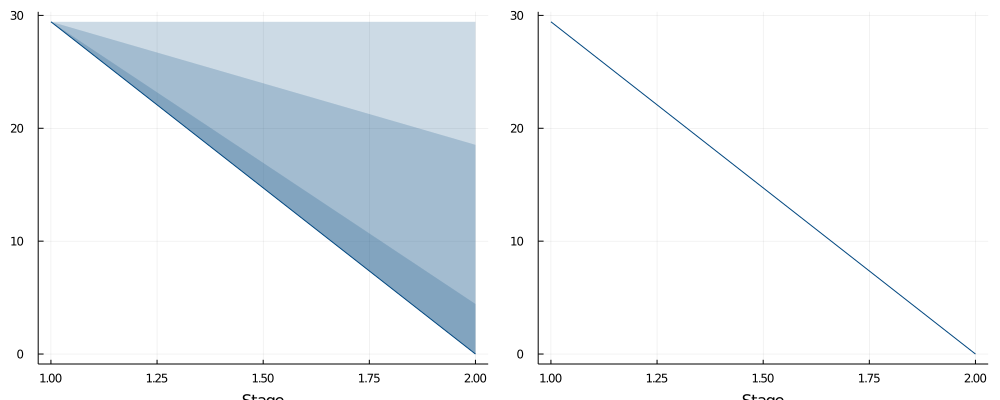

In [4]:
using Plots
plot(
    SDDP.publication_plot(results, title = "Stock") do data
        return data[:stock].out
    end,
    SDDP.publication_plot(results, title = "Purchase") do data
        return data[:reserve]
    end,
    xlabel = "Stage",
    layout = (1, 2),
    size = (1000, 400)
)


In [6]:
100-(3/4*100^2*p/q)^(1/3)

27.887521484629602

In [7]:
p*28+q*(100-28)^4/(3*100^2)

45.915904